In [23]:
#Data loading, preprocessing, training
import numpy as np
import time


with open('updated_ocean.csv', 'r') as file:
    lines = file.readlines()

x_data = []
y_data = []

for i, line in enumerate(lines[1:], start=2):
    parts = line.strip().split(',')
    if len(parts) < 10:
        continue
    try:
        longitude = float(parts[0])
        latitude = float(parts[1])
        age = float(parts[2])
        total_rooms = float(parts[3])
        total_bedrooms = float(parts[4])
        population = float(parts[5])
        households = float(parts[6])
        income = min(float(parts[7]), 15)
        value = float(parts[8])
        ocean_proximity = float(parts[9])

        if total_rooms == 0 or households == 0:
            continue

        rooms_per_person = total_rooms / population if population != 0 else 0
        bedrooms_per_room = total_bedrooms / total_rooms
        income_per_household = income / households
        rooms_per_household = total_rooms / households
        population_per_household = population / households

        features = [
            longitude,
            latitude,
            age,
            income,
            rooms_per_person,
            bedrooms_per_room,
            rooms_per_household,
            population_per_household,
            income_per_household,
            ocean_proximity
        ]

        x_data.append(features)
        y_data.append(value)
    except:
        continue

x_data = np.array(x_data)
y_data = np.array(y_data)

# Clip outliers
y_data = np.clip(y_data, a_min=None, a_max=np.percentile(y_data, 99))

# Standardize features
x_mean = x_data.mean(axis=0)
x_std = x_data.std(axis=0)
x_data = (x_data - x_mean) / x_std
x_data = np.nan_to_num(x_data)

# Add bias term
x_data = np.hstack([np.ones((x_data.shape[0], 1)), x_data])

# Normalize target
y_min = y_data.min()
y_max = y_data.max()
y_data = (y_data - y_min) / (y_max - y_min)
y_data = y_data.reshape(-1, 1)

# Train-test split
split = int(0.8 * len(x_data))
x_train, x_test = x_data[:split], x_data[split:]
y_train, y_test = y_data[:split], y_data[split:]

# Gradient Descent with L2 regularization
weights = np.random.randn(x_train.shape[1], 1) * 0.01
alpha = 0.01
epochs = 10000
lambda_reg = 0.1
n = x_train.shape[0]

costs = []

start_time = time.time()

for epoch in range(epochs):
    predictions = x_train @ weights
    errors = predictions - y_train

    cost = (np.sum(errors**2) / (2*n)) + (lambda_reg / 2) * np.sum(weights[1:]**2)
    costs.append(cost)

    gradient = (x_train.T @ errors) / n + lambda_reg * weights
    gradient[0] -= lambda_reg * weights[0]
    weights -= alpha * gradient

end_time = time.time()
training_time = end_time - start_time

print("Training time (seconds):", training_time)

Training time (seconds): 49.77848410606384


In [24]:

def evaluate(x, y_true, weights):
    preds = x @ weights
    errors = y_true - preds
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    y_mean = np.mean(y_true)
    total_var = np.sum((y_true - y_mean)**2)
    residual_var = np.sum(errors**2)
    r2 = 1 - residual_var / total_var
    return mae, rmse, r2

eval_start = time.time()
mae, rmse, r2 = evaluate(x_test, y_test, weights)

custom_input = np.array([
    -122.23,
    37.88,
    41,
    8.3252,
    880 / 322,
    129 / 880,
    880 / 126,
    322 / 126,
    8.3252 / 126,
    259212
])

custom_input = (custom_input - x_mean) / x_std
custom_input = np.nan_to_num(custom_input)
custom_input = np.insert(custom_input, 0, 1.0)
predicted_normalized = custom_input @ weights
predicted_normalized = np.clip(predicted_normalized, 0, 1)
predicted_value = predicted_normalized * (y_max - y_min) + y_min

eval_end = time.time()
evaluation_time = eval_end - eval_start

print("Predicted median_house_value:", predicted_value.item())
print("MAE:", mae * (y_max - y_min))
print("RMSE:", rmse * (y_max - y_min))
print("R² Score:", r2)
print("Evaluation + Prediction time (seconds):", evaluation_time)
print("Trained weights:", weights.flatten())


Predicted median_house_value: 400959.5058547612
MAE: 48515.65502790839
RMSE: 68558.204895204
R² Score: 0.677438840657757
Evaluation + Prediction time (seconds): 0.010319232940673828
Trained weights: [ 0.38914547 -0.02669388 -0.03344967  0.02290499  0.14496131  0.05915814
  0.0179122  -0.03939036 -0.0077711  -0.00260295  0.05492467]


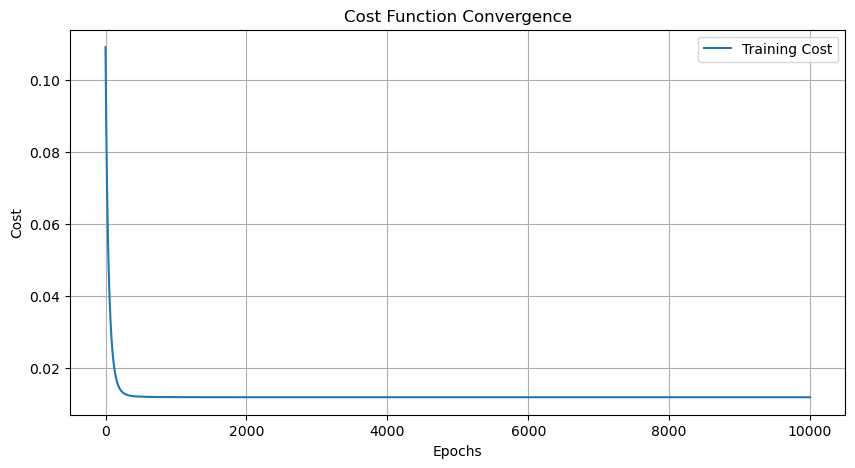

In [25]:
# Plot cost function convergence
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(costs)), costs, label='Training Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost Function Convergence')
plt.grid(True)
plt.legend()
plt.show()

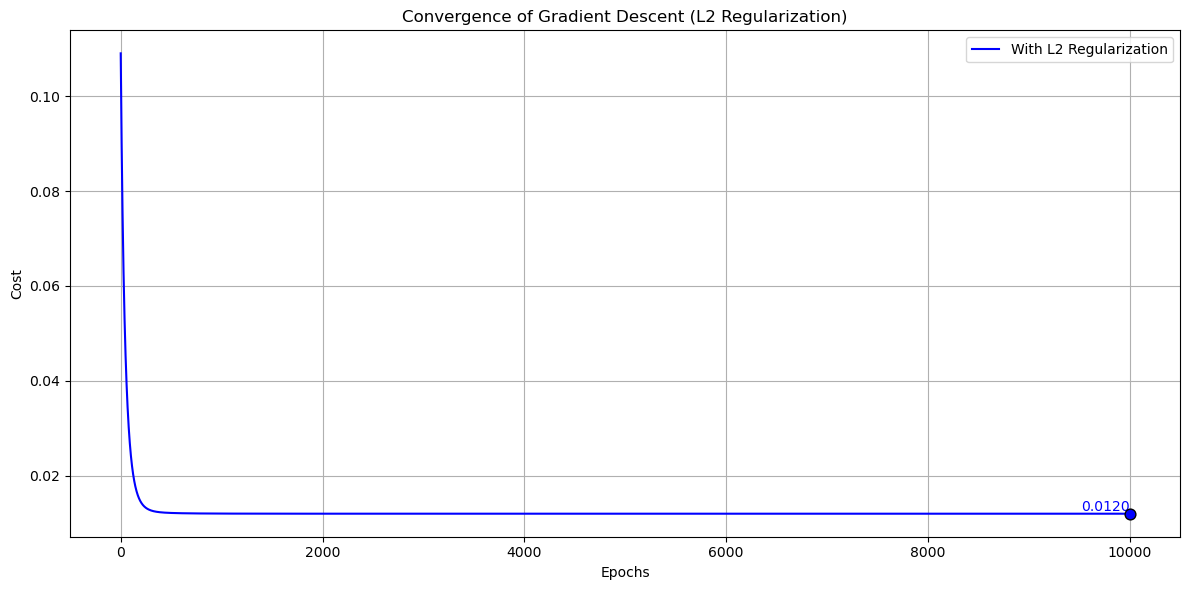

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot cost over epochs for the trained model
plt.plot(costs, label='With L2 Regularization', color='blue')

# Highlight final cost point
plt.scatter(len(costs) - 1, costs[-1], color='blue', s=60, edgecolor='black', zorder=5)

# Annotate final cost value
plt.text(len(costs) - 1, costs[-1], f'{costs[-1]:.4f}', color='blue', ha='right', va='bottom')

# Add labels and grid
plt.title('Convergence of Gradient Descent (L2 Regularization)')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()